# Dataset ARPA Piemonte
Registrazione delle misure recuperate dal database ARPA Piemonte.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [29]:
dataset_id <- "ARPAPiemonte"
state <- "Piemonte"


In [45]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [49]:
daily_dataset <- load_daily_data.arpapiemonte() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1976100,105.6,3739895,199.8,NA,3739895,199.8
Vcells,12929795,98.7,48360283,369.0,16384,48360283,369.0


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [3]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)
qc_database$data |>
    compute() |>
    nrow()
checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1870388,99.9,3312215,176.9,NA,3312215,176.9
Vcells,7803692,59.6,80429268,613.7,16384,100535256,767.1


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

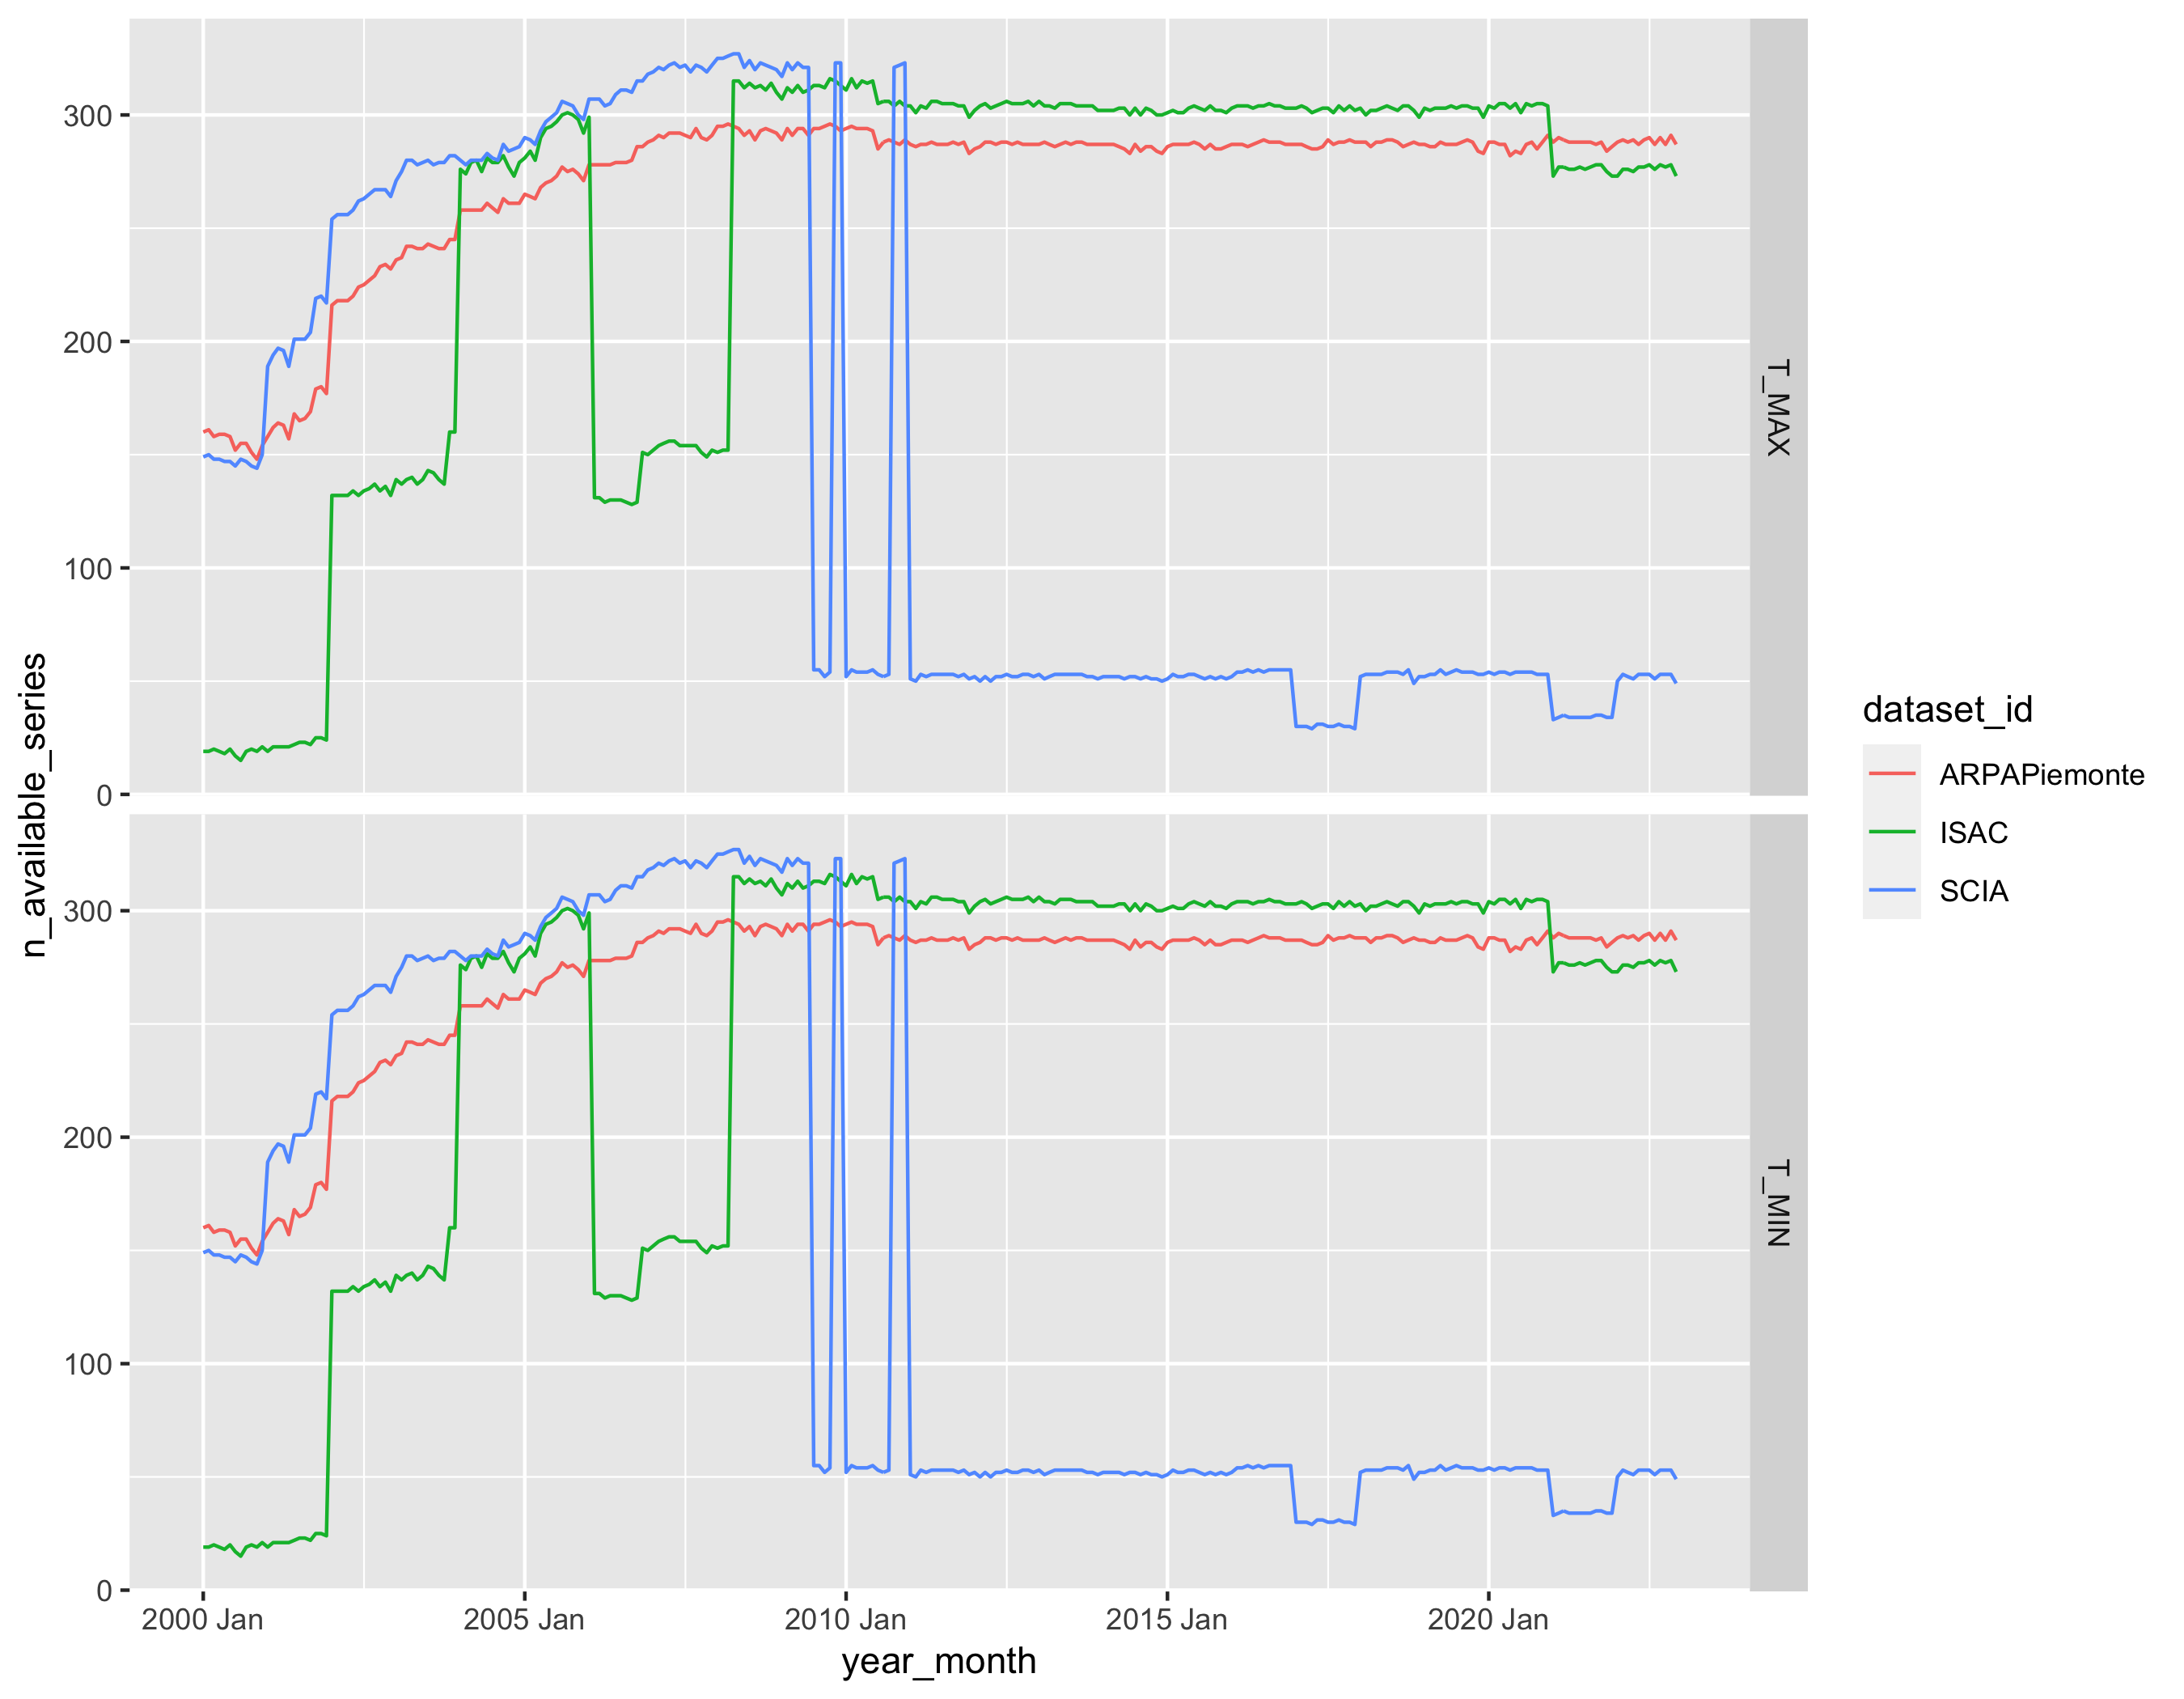

In [9]:
qc_database <- open_checkpoint(dataset_id, "qc1")
others <- concat_databases(
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries)
)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = others,
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


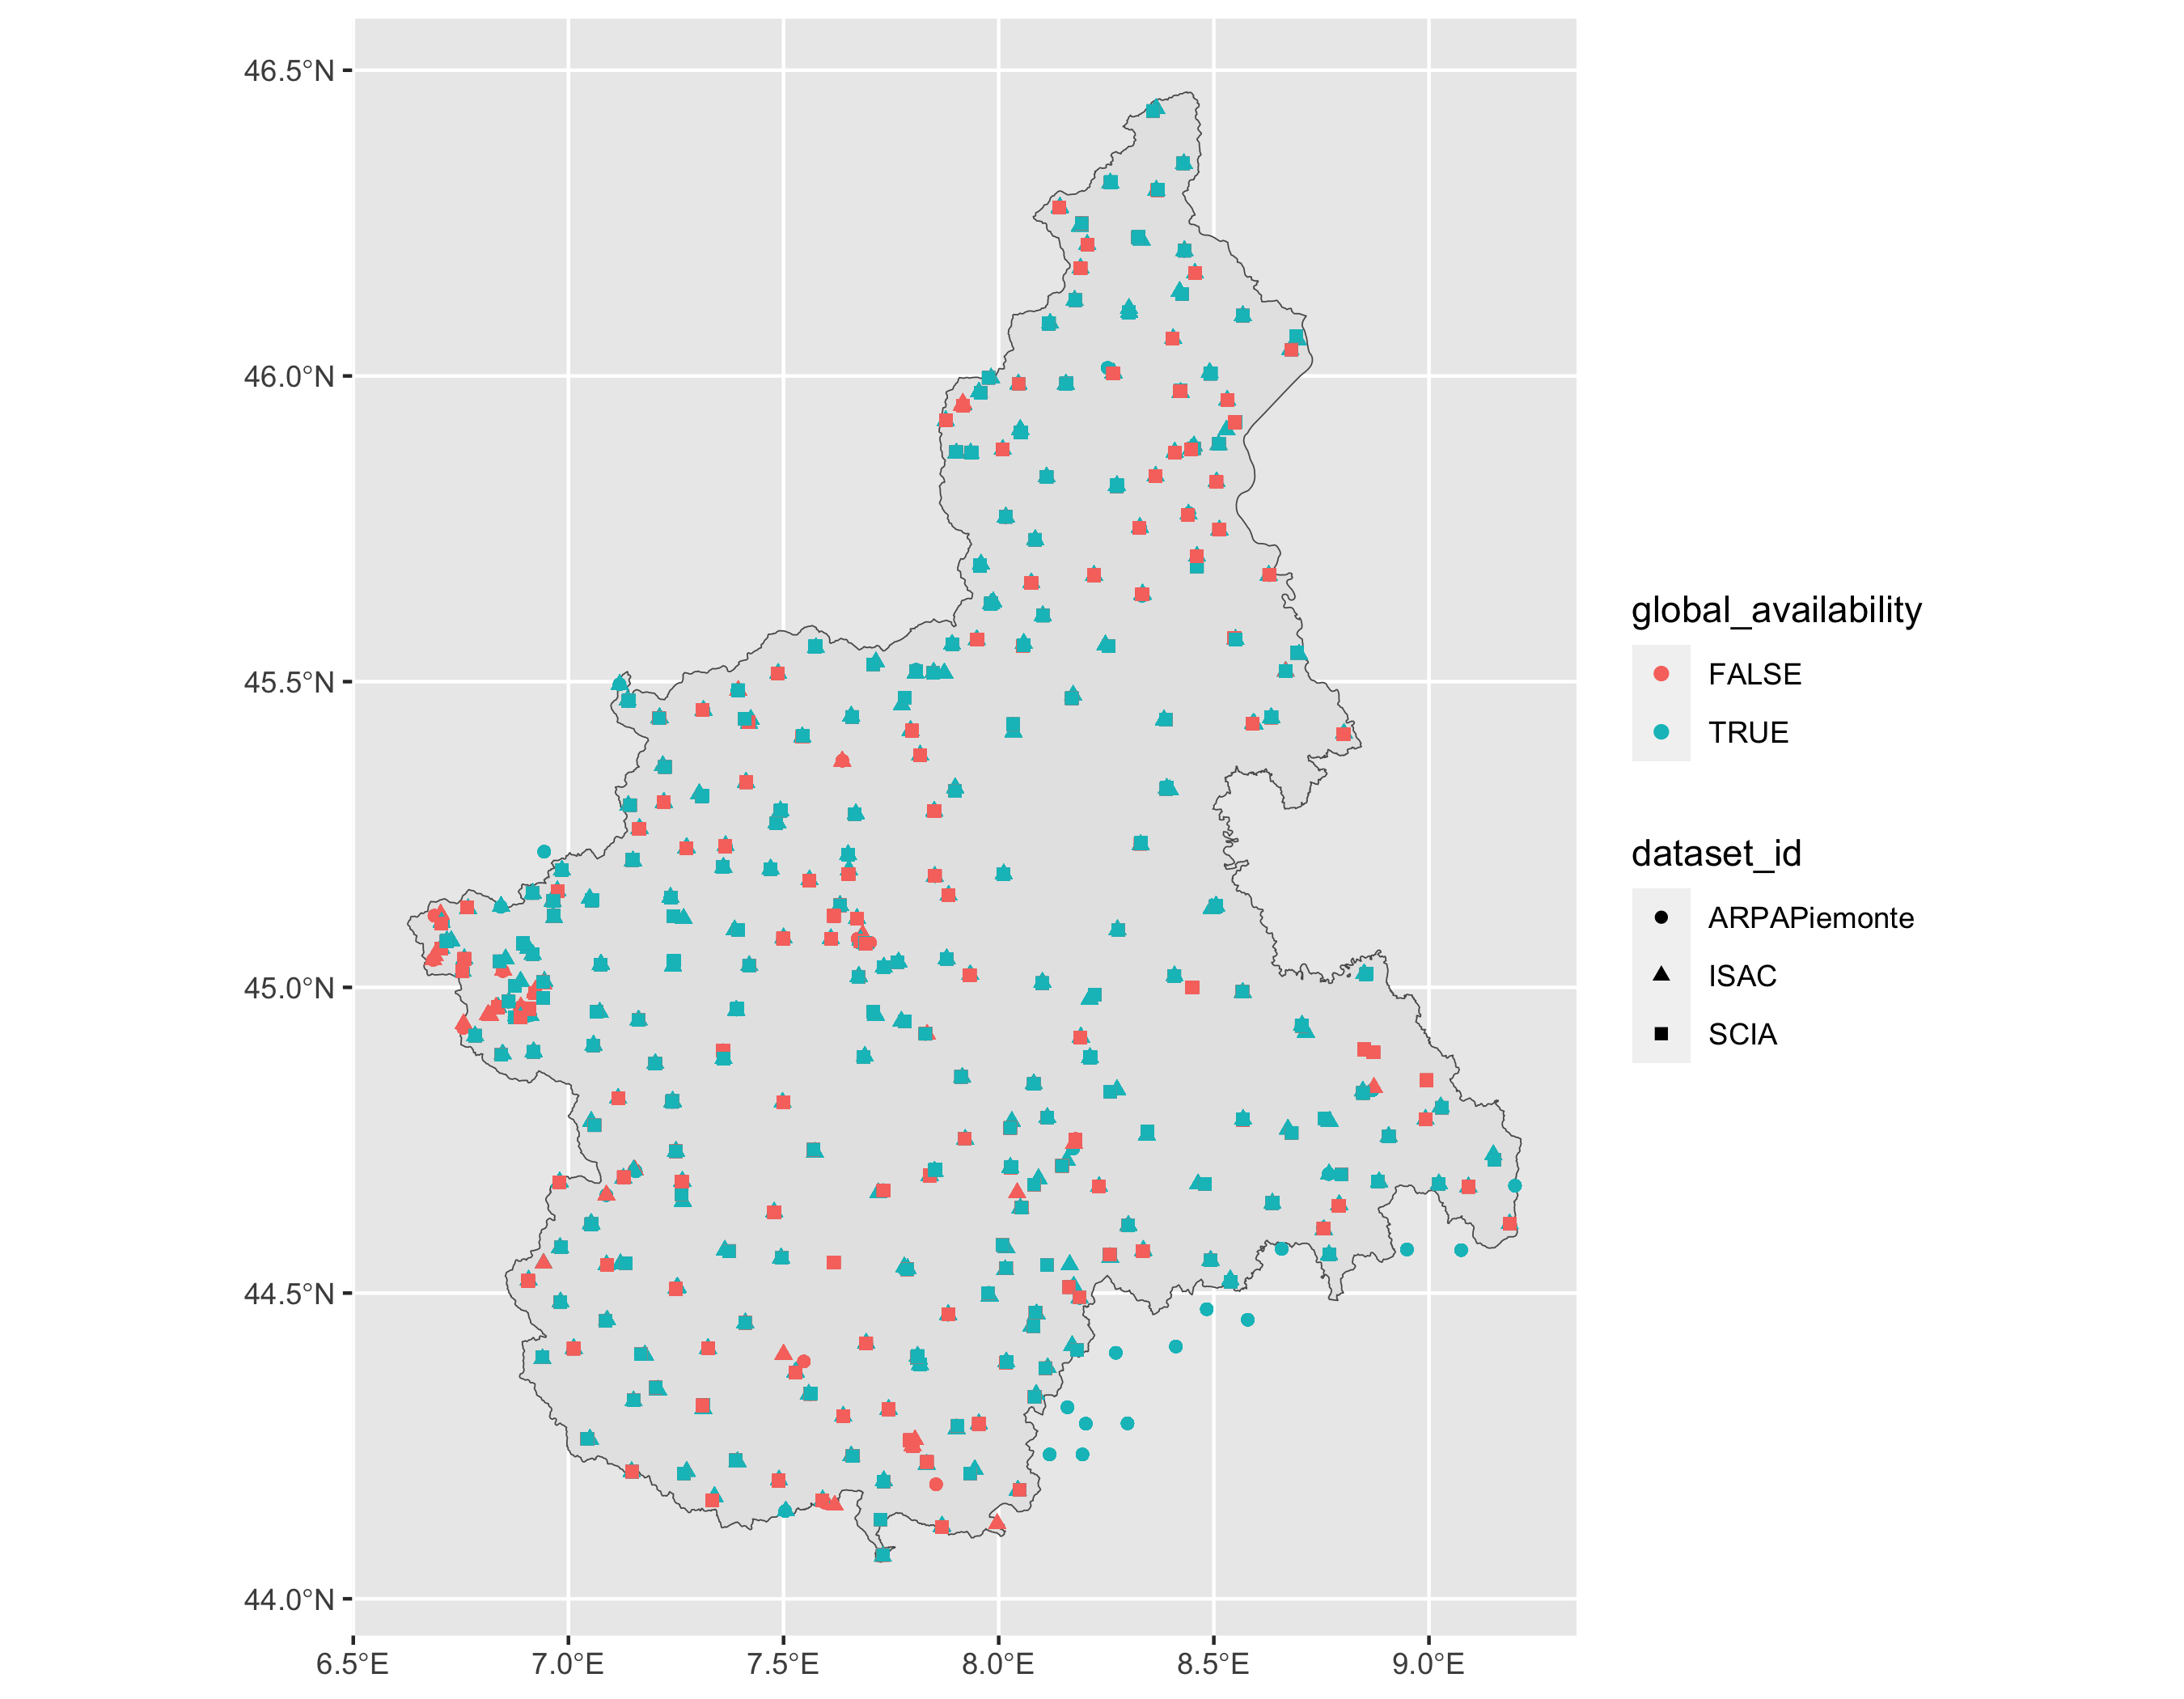

In [10]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, concat_tables(qc_database$meta, others$meta), state_boundaries)
p


In [11]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2362389,126.2,5944007,317.5,NA,5944007,317.5
Vcells,18503872,141.2,405902988,3096.8,16384,507378734,3871.0


## Merging
Gap-filling con SCIA. è utile per il primo periodo e non sembra complicato

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [53]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries |> sf::st_buffer(dist = units::set_units(5, "km")))
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = 4,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_state)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2373231,126.8,5100375,272.4,NA,5100375,272.4
Vcells,17969716,137.1,354646096,2705.8,16384,1760656144,13432.8


In [54]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,5
FALSE,TRUE,285
TRUE,FALSE,684
TRUE,TRUE,2


station_id.x,n
<chr>,<int>
0004ed89864d93faed7180aa4d0acff3,4
00ad5956dfc10953787b41c9812f8917,4
13853d54b2629f849e117badd505e1ed,4
18245668b8e8e8f600da41e9c6114e33,4
190ed069caf7125cf476364e8ed61a3a,4
216c32900683101f58a26488e1c375b6,4
2371f361c57530d0690f4ce6e0fef492,4
259eb35eee5aa8852b6b7be3407e442f,4
281224e9a6816f46756945c36179110e,4


station_id.y,n
<chr>,<int>


In [55]:
# Tutte le correzioni sono entro 1°C
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "merge_scia")
save_match_list(combination_results$match_list, dataset_id, "merge_scia")
rm(combination_results)


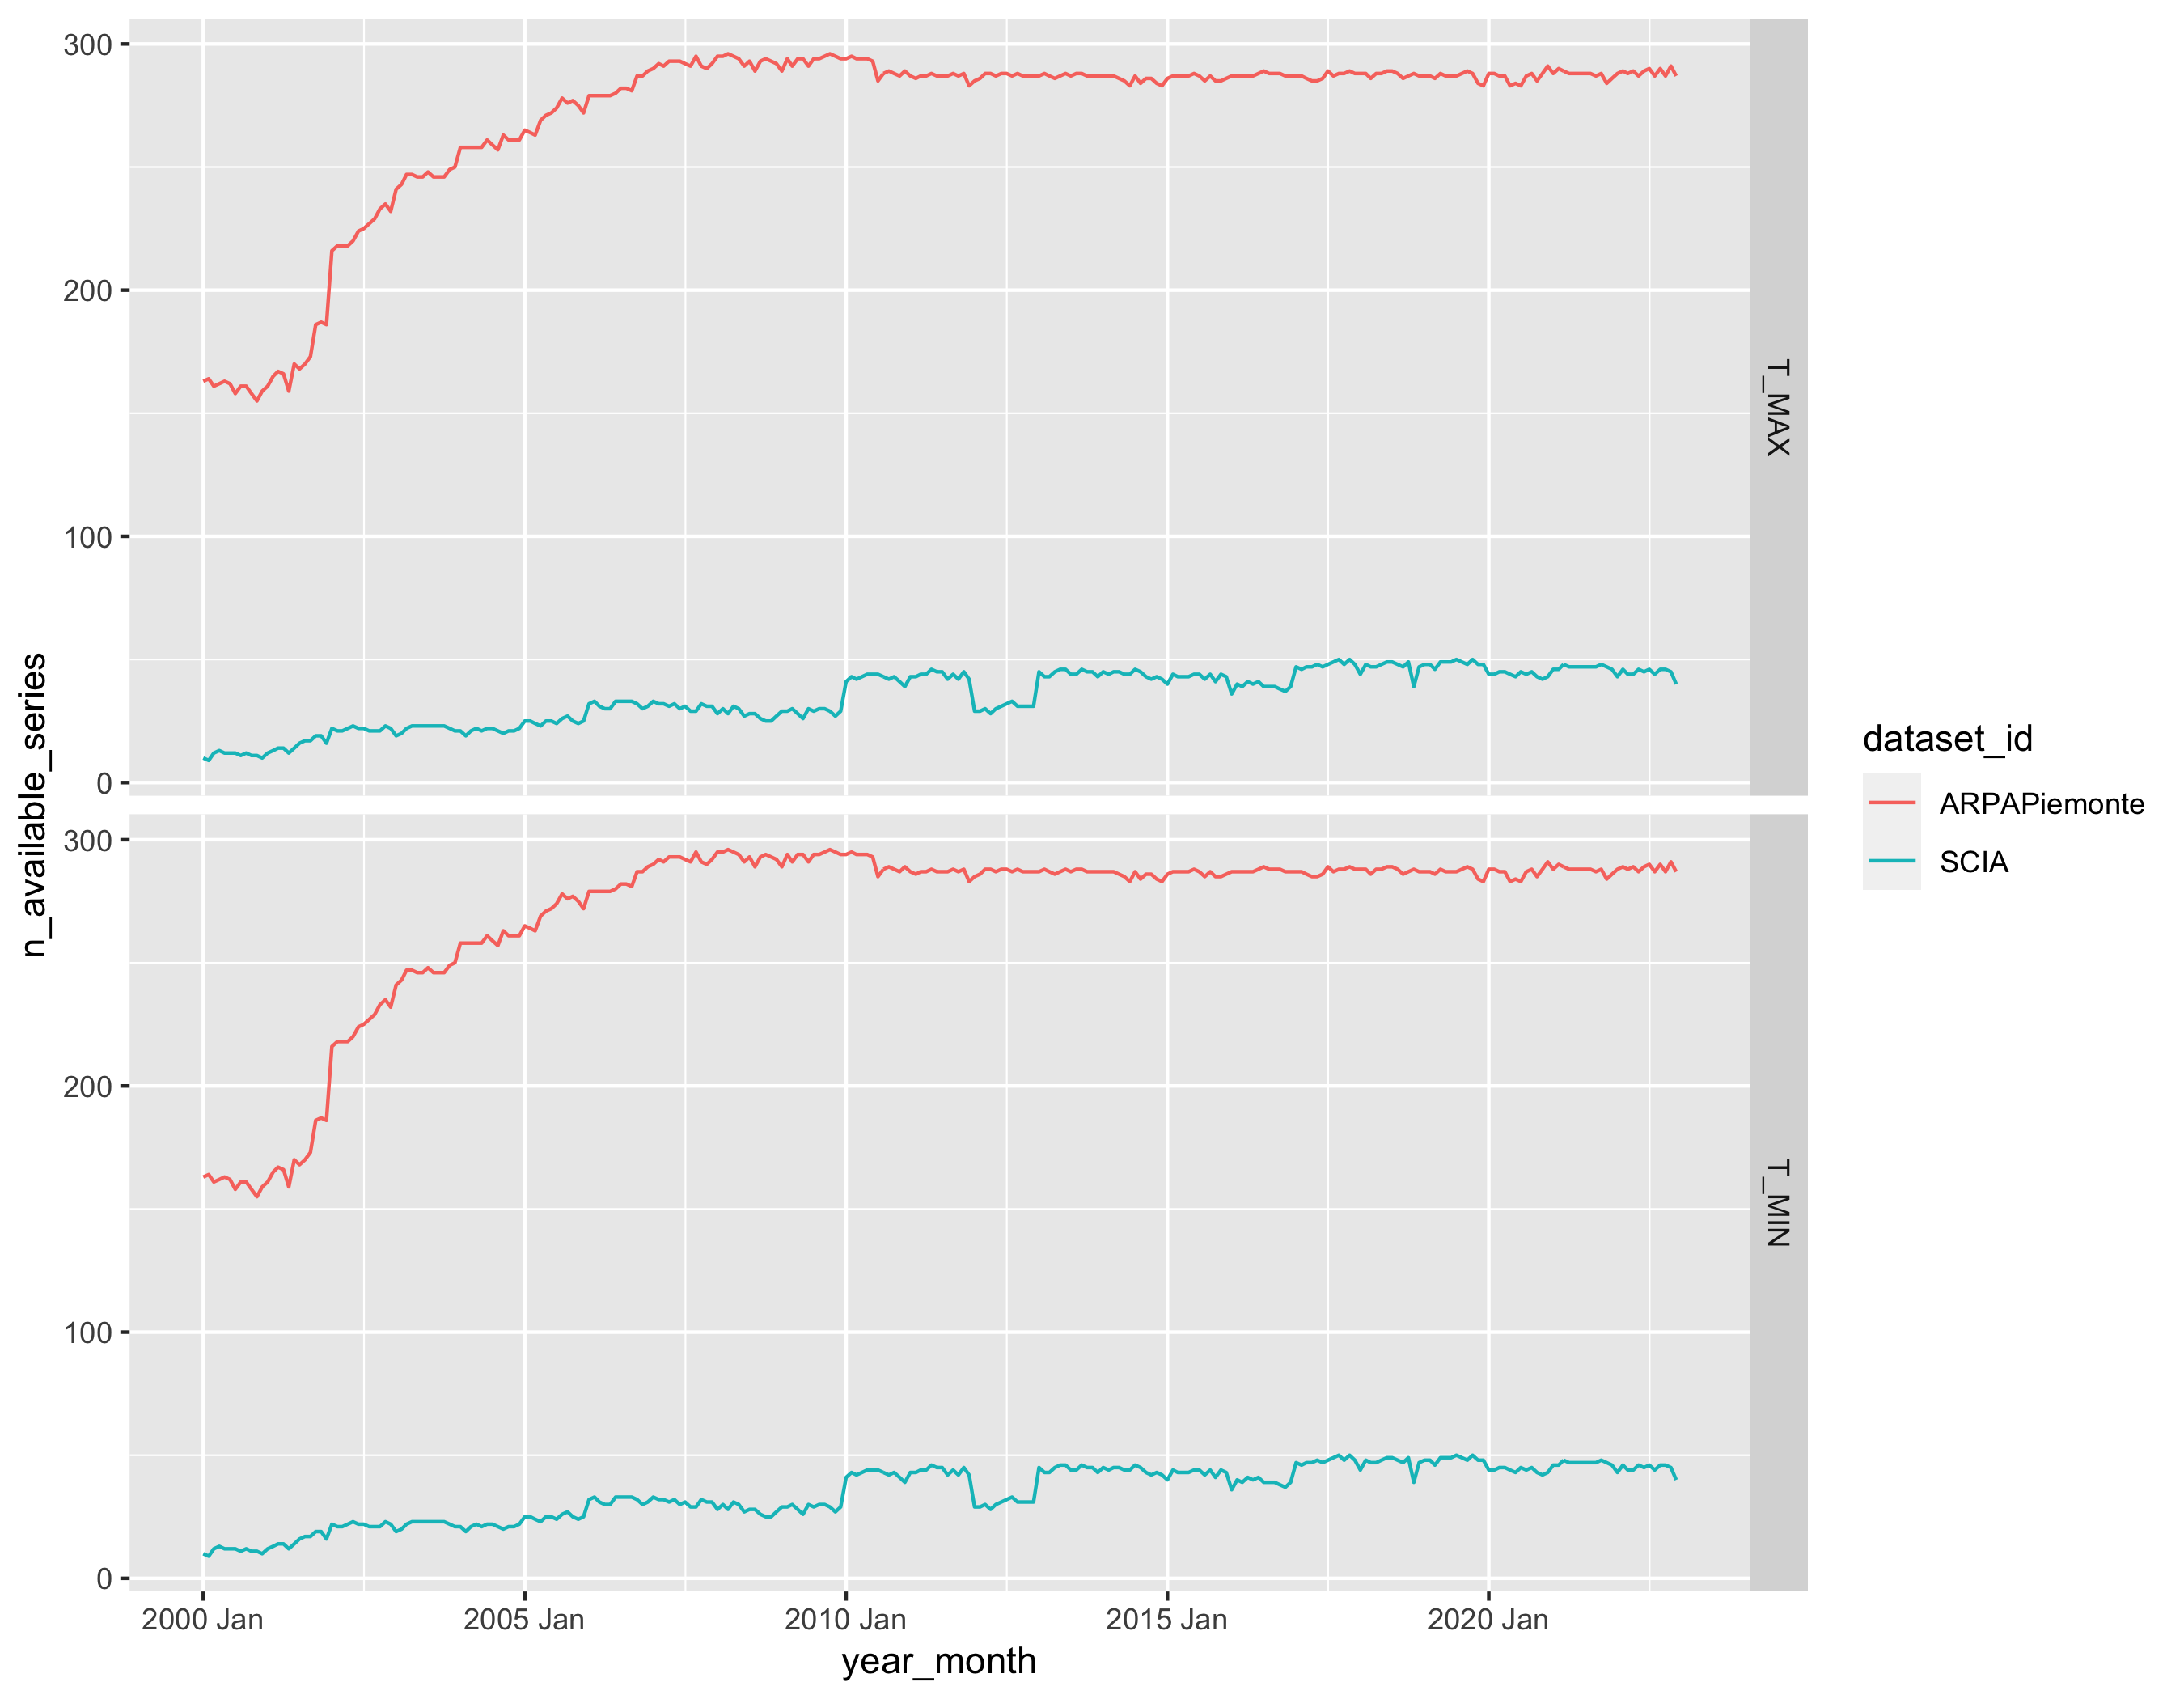

In [56]:
combined_database <- open_checkpoint(dataset_id, "merge_scia")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


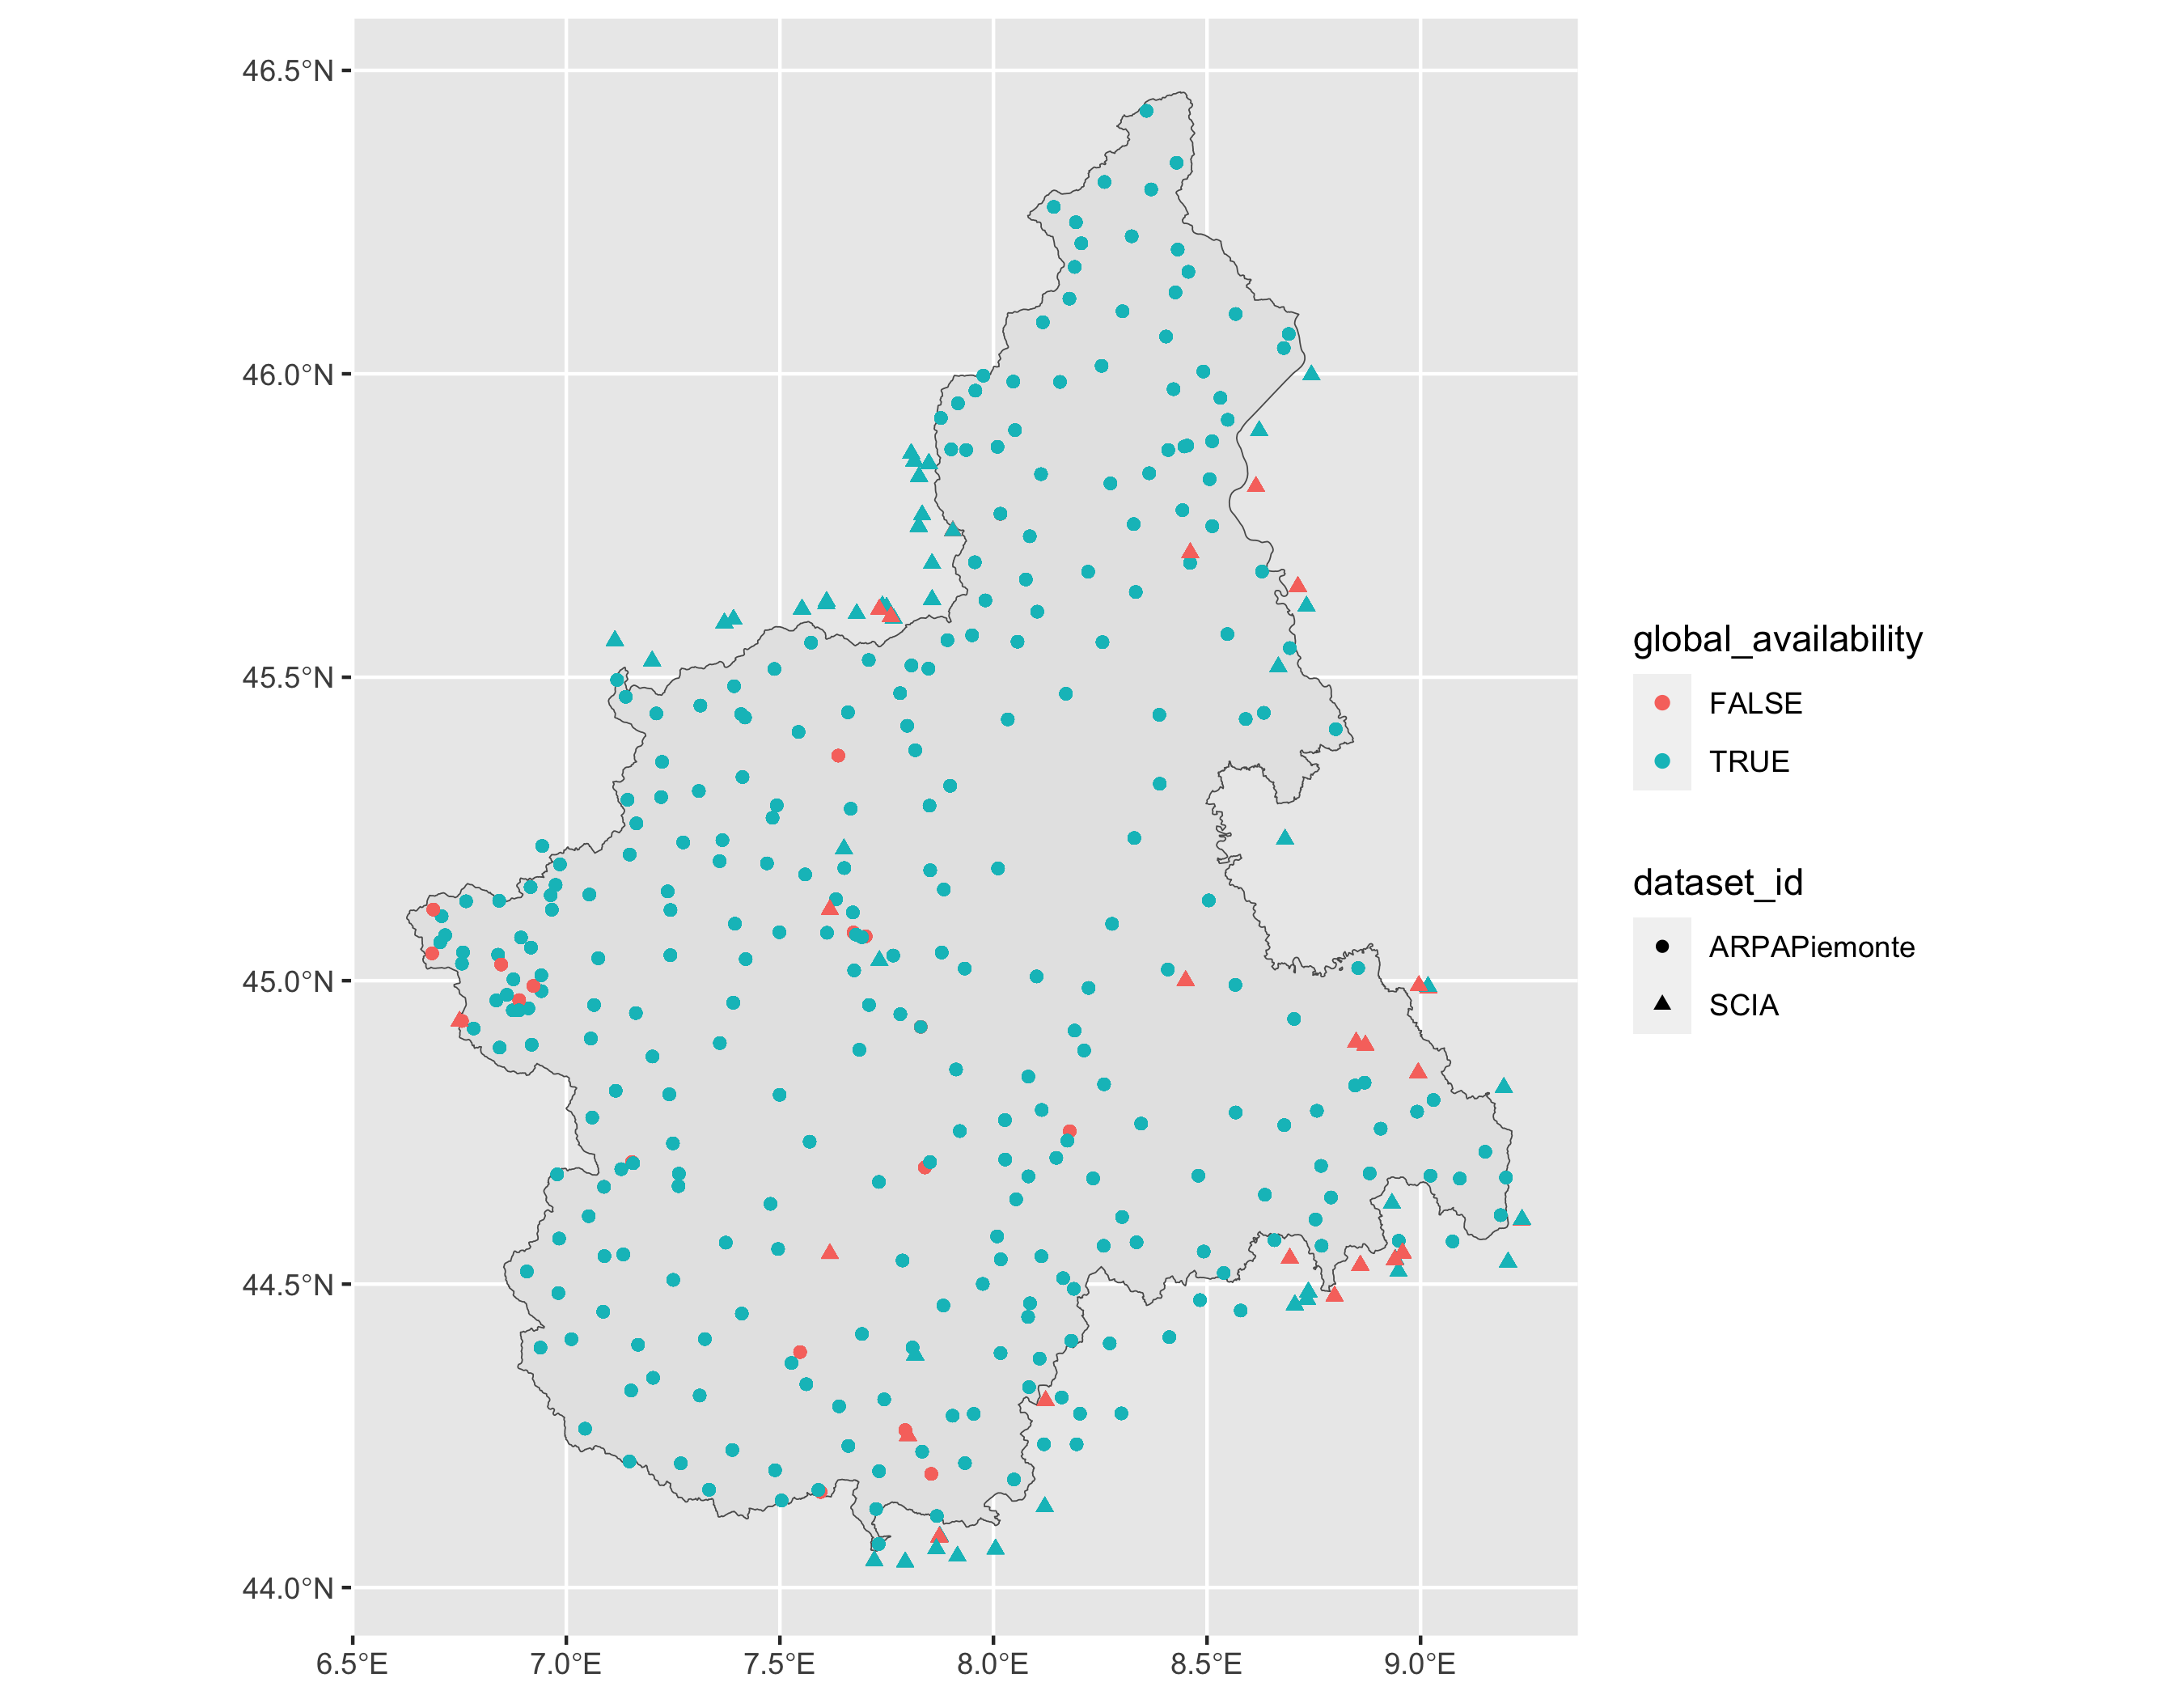

In [57]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [58]:
rm(ymonthly_avail)
rm(climats)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2374000,126.8,5100375,272.4,NA,5100375,272.4
Vcells,17944973,137.0,226973502,1731.7,16384,1760656144,13432.8


### Merge interno
Per combinare serie su periodi diversi

In [59]:
merge_left_if <- function(analysis_pairs) {
    analysis_pairs |> filter((valid_days.x > valid_days.y) | (valid_days.x == valid_days.y & delT > 0))
}


In [60]:
merged_scia <- open_checkpoint(dataset_id, "merge_scia")
analysis_results <- perform_analysis_single(
    merged_scia,
    dist_km = 2, # dalla mappa sembra che i metadati siano in gran parte coincidenti
    first_date,
    last_date,
    file.path(str_to_lower(state), "internal.xlsx"),
)

rm(merged_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2374792,126.9,5100375,272.4,NA,5100375,272.4
Vcells,7984308,61.0,181578802,1385.4,16384,1760656144,13432.8


In [61]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,124
TRUE,FALSE,60


station_id.x,n
<chr>,<int>
204840a41977845a82f04421250b51d0,4
2cb53cd454ab69770445006d6d567686,4
55b41a7b4f2fb4a598cf69a4459b784a,4


station_id.y,n
<chr>,<int>
204840a41977845a82f04421250b51d0,4
2cb53cd454ab69770445006d6d567686,4
55b41a7b4f2fb4a598cf69a4459b784a,4


In [62]:
# Tutte le correzioni sono entro 1°C
combination_results <- build_combined_database(analysis_results, use_corrections = FALSE, checks = TRUE, test_bounds = 1, match_selectors = merge_left_if)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)


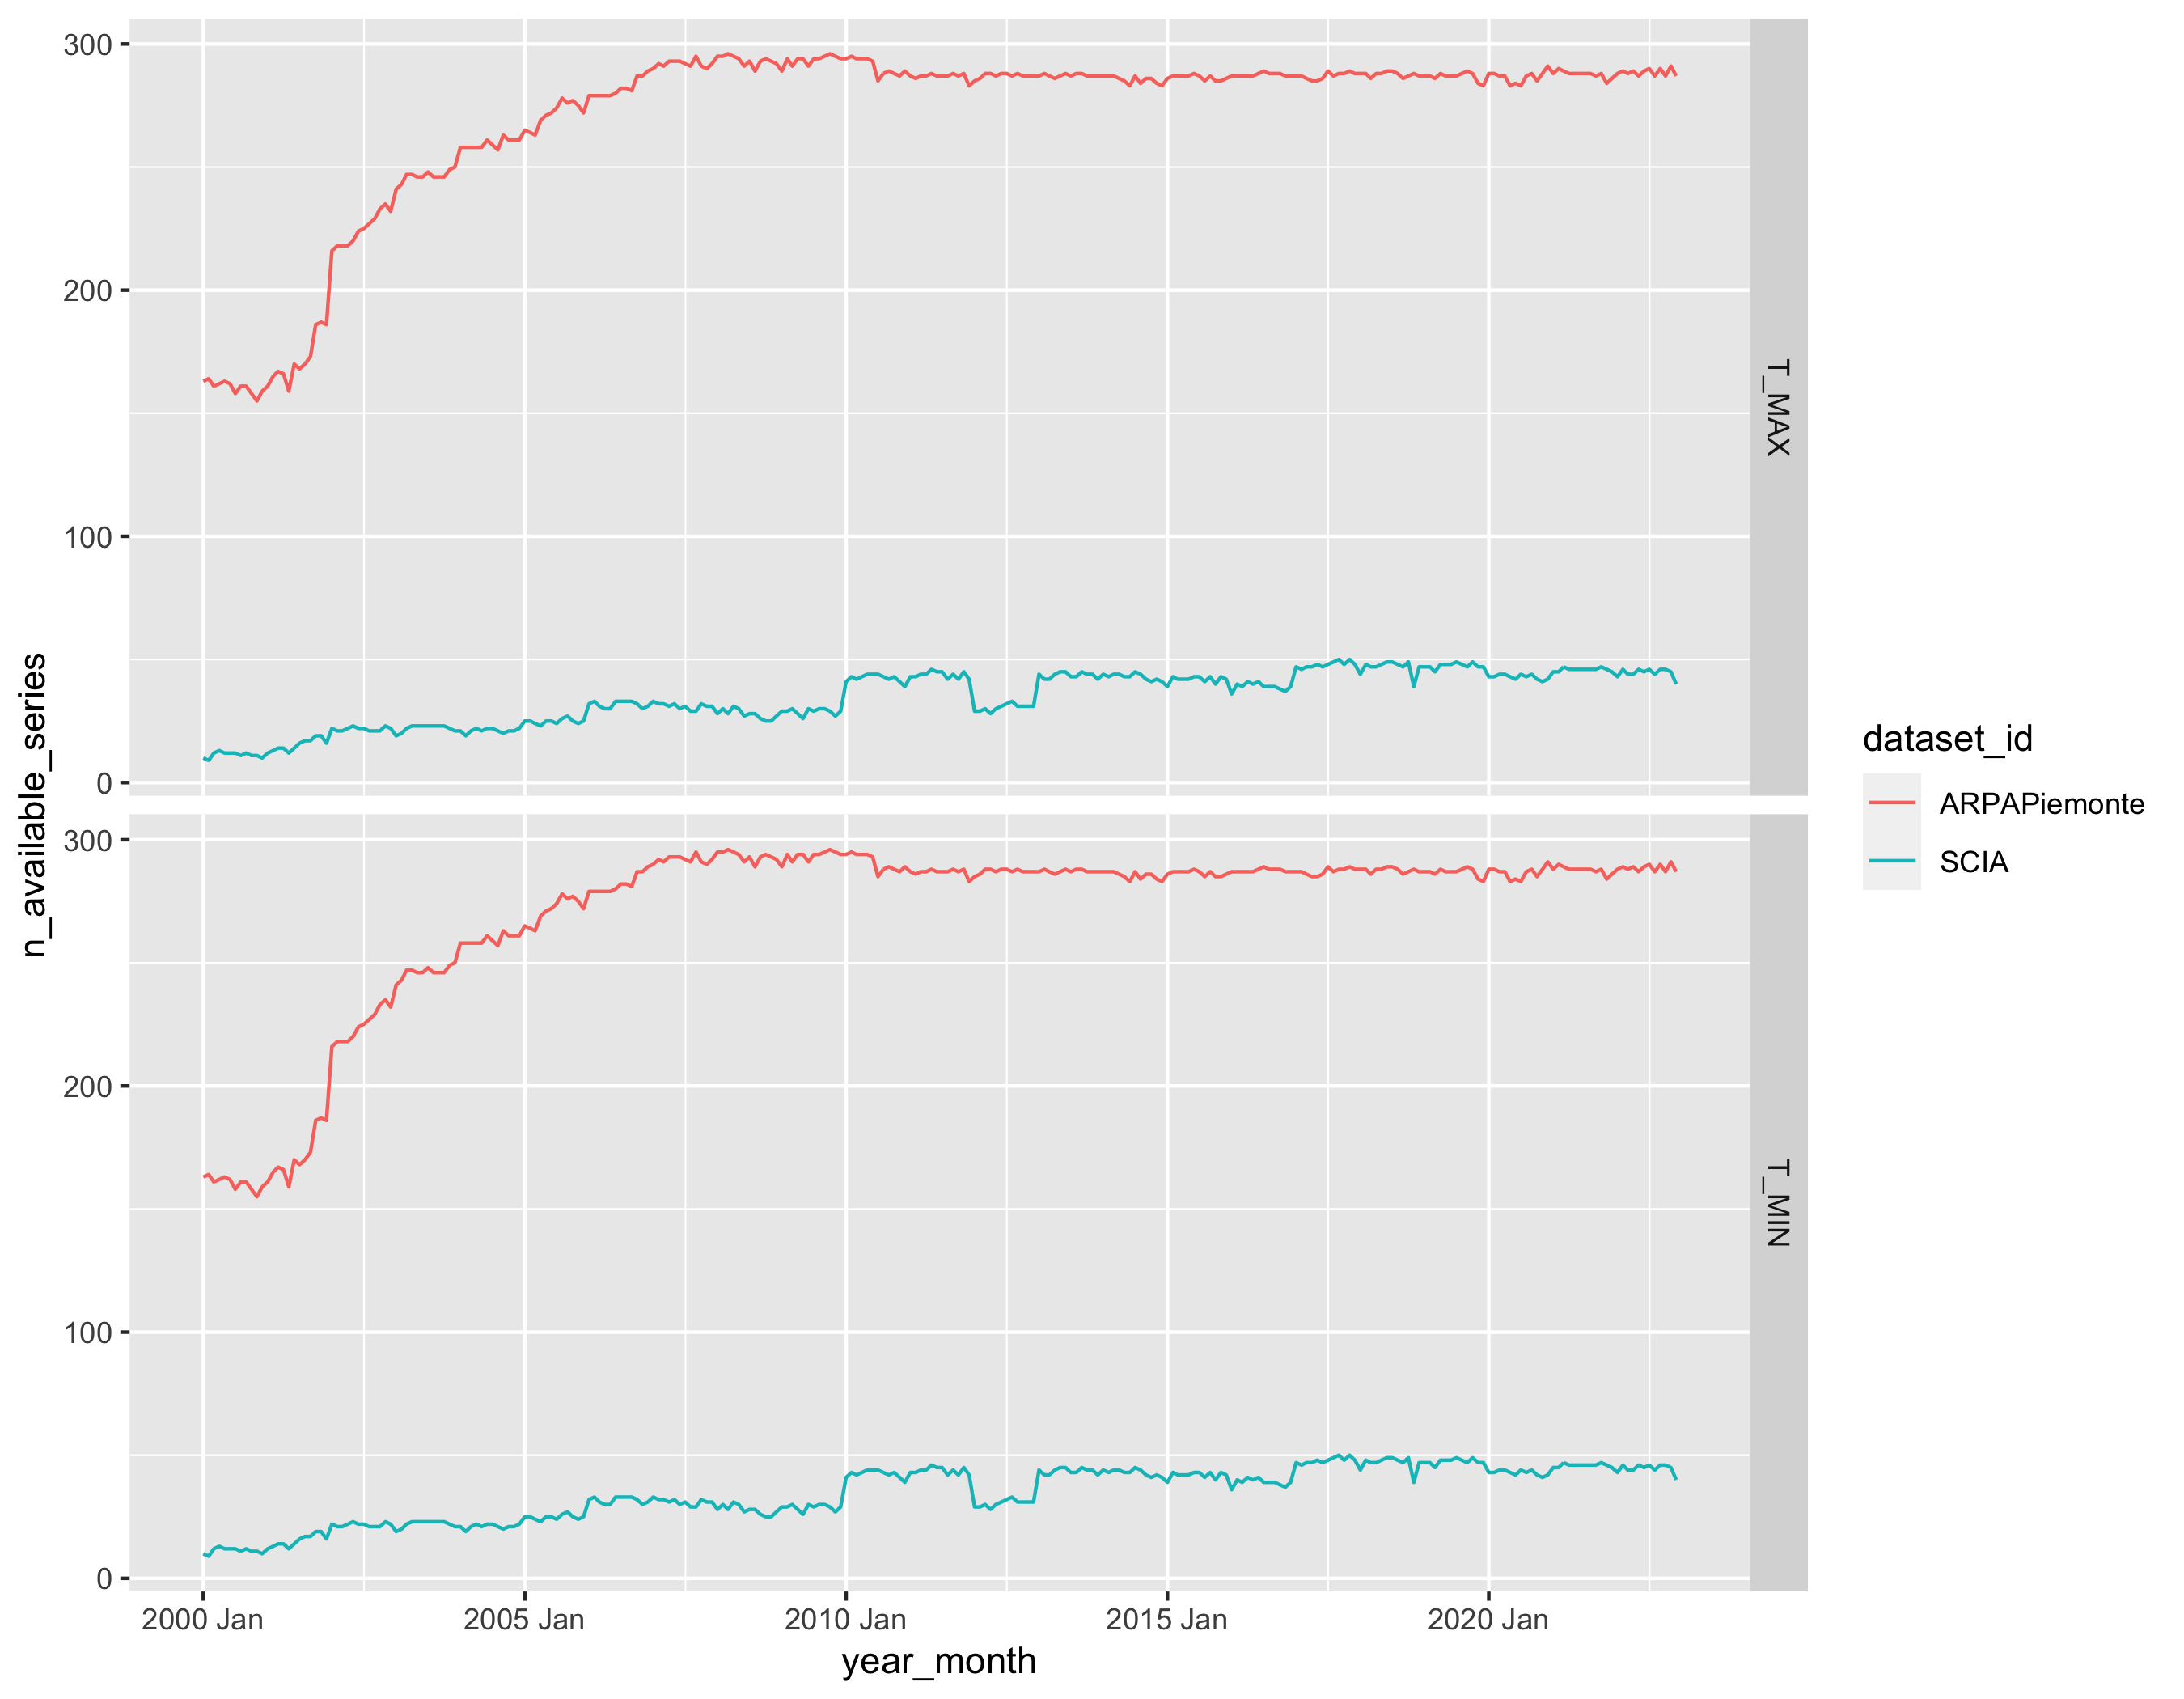

In [63]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


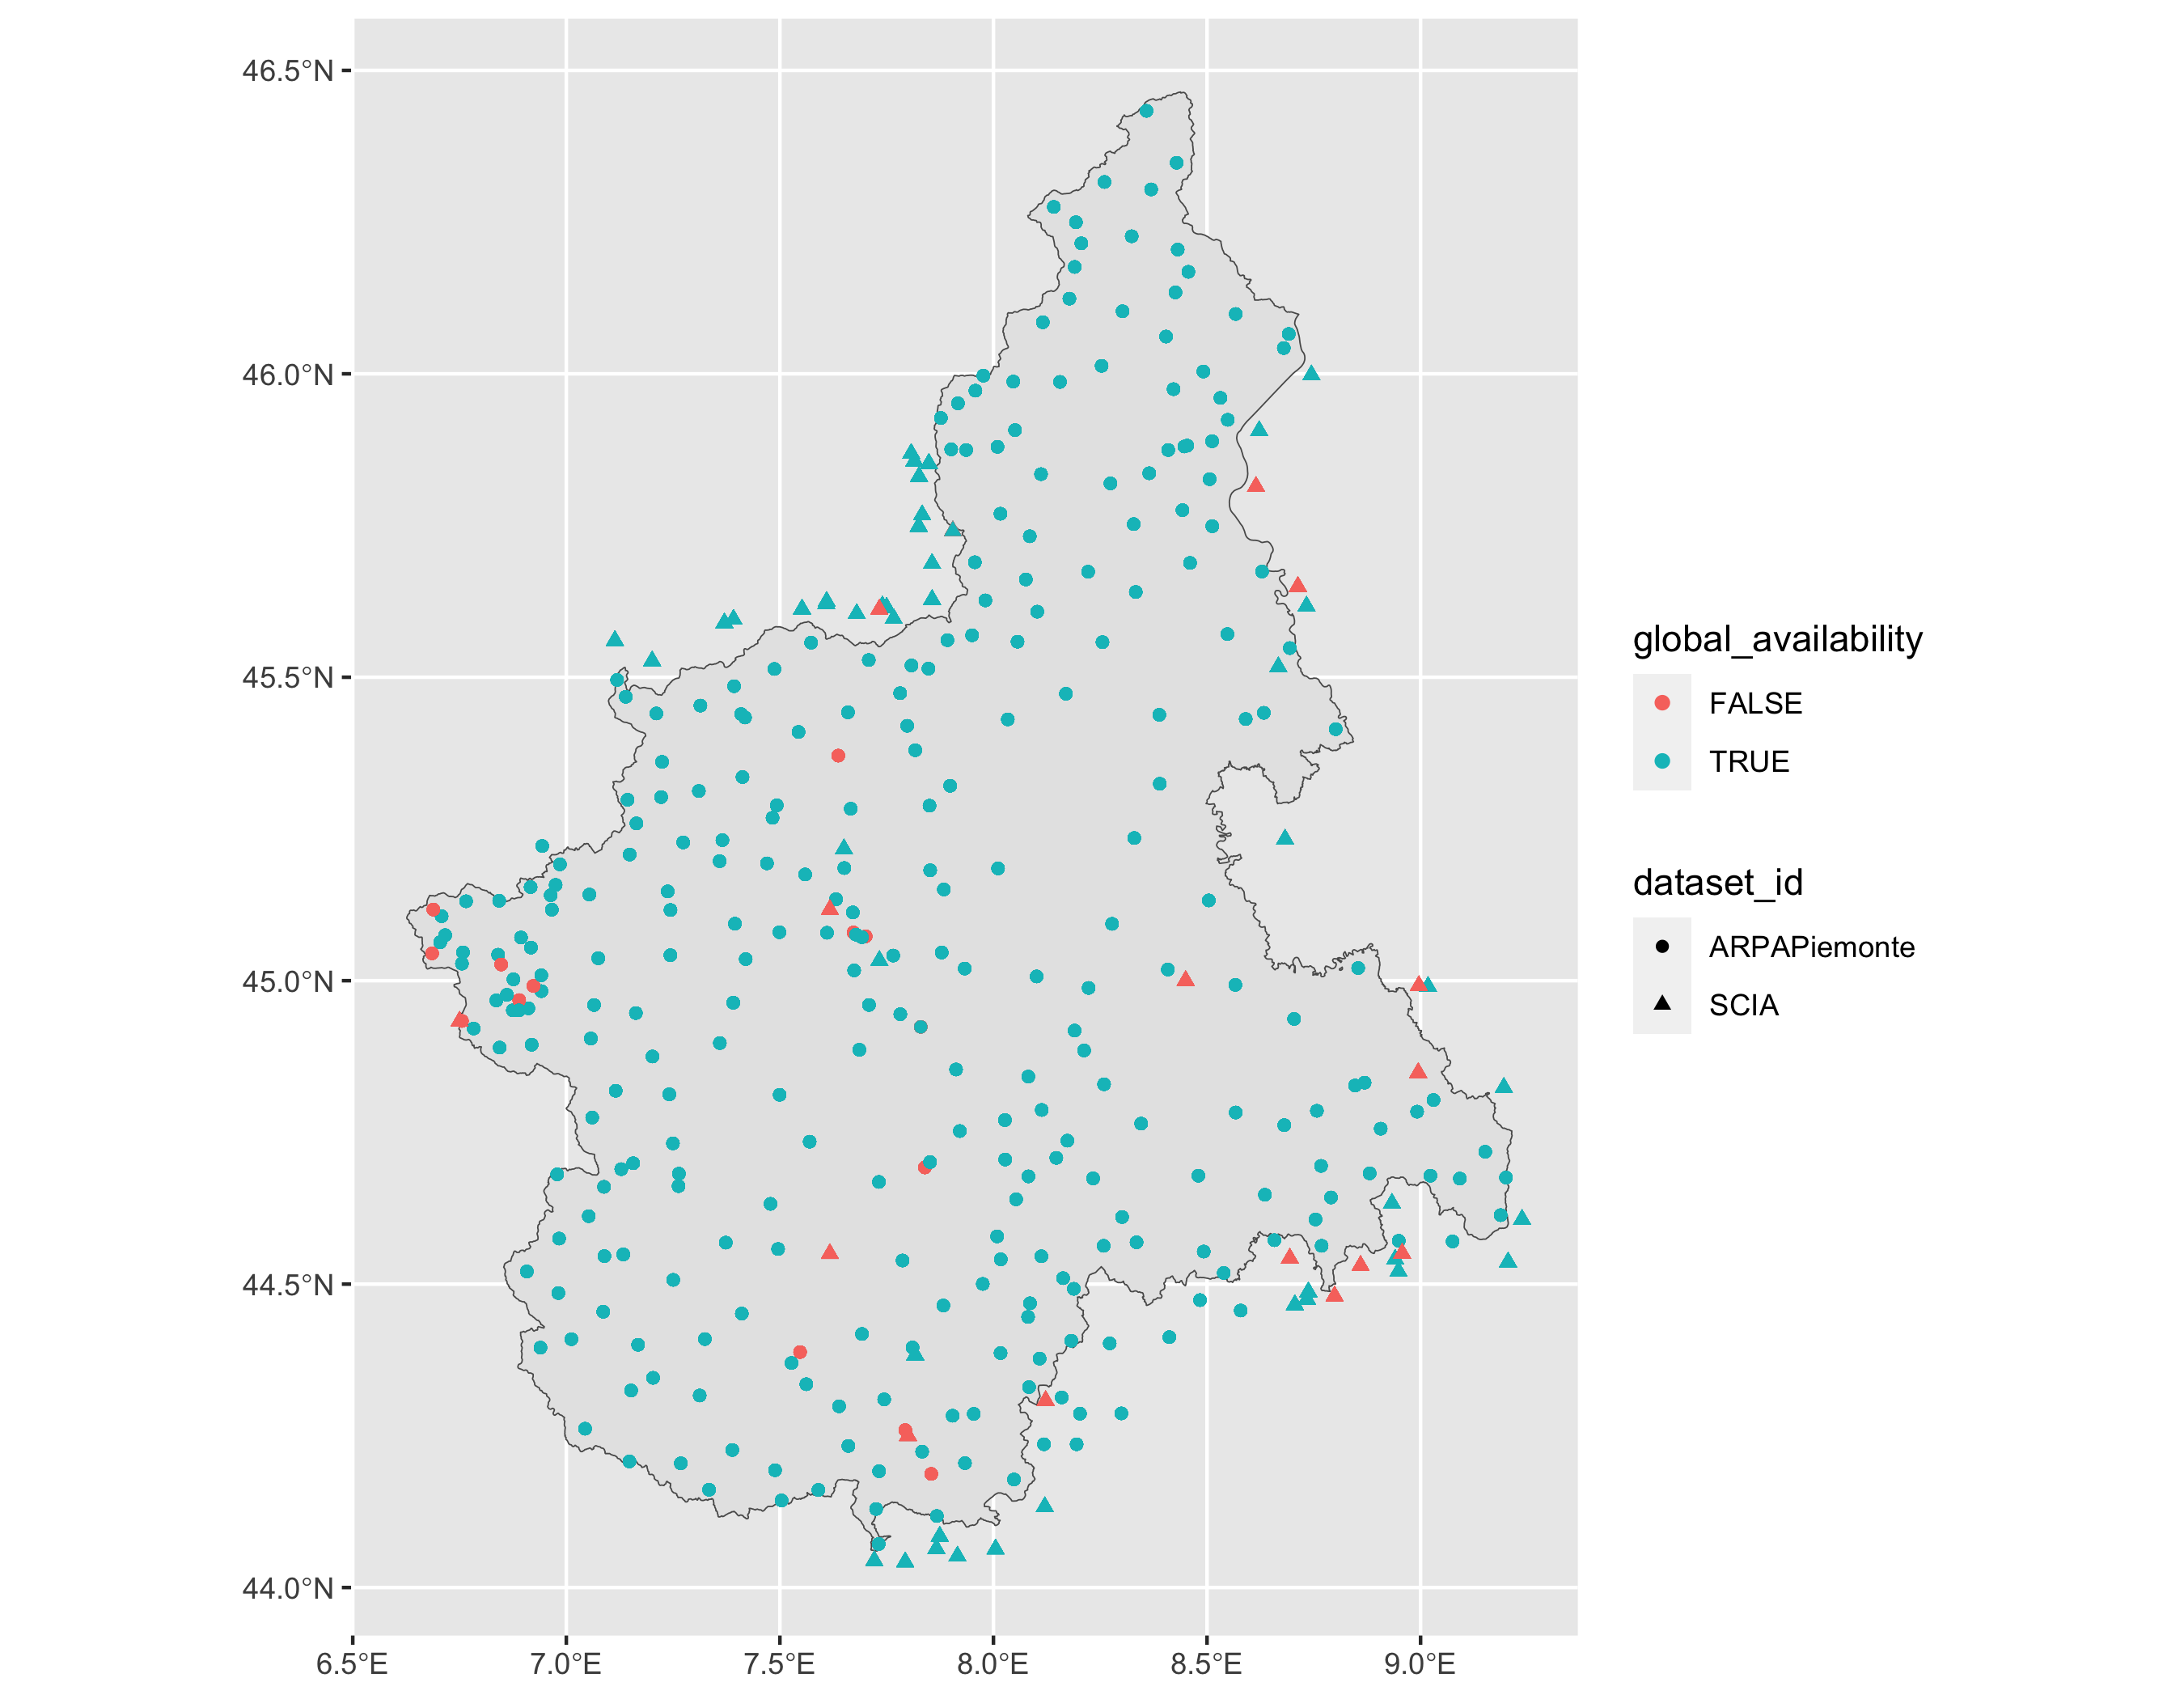

In [64]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [65]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()


[1] 730

In [ ]:
# Lanciare da terminale
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(, "merged") |>
    launch_leaflet()
